In [1]:
### Merge results of SC2 nodes
import pandas as pd
import sqlite3
import numpy as np
import json

FONT_SIZE = 14

def load_data_from_db(dbs):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = 'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM dbstatus WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        df.drop('id', axis=1, inplace=True)
        df.drop('totalblocks', axis=1, inplace=True)
        df.drop('totaltransactions', axis=1, inplace=True)
        df.drop('blocks', axis=1, inplace=True)
        df = df.rename(columns={'ts': 'timestamp'})
        
        df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
                  'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)
        conn.close()
    return sc

def load_data_from_db_min(dbs):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = 'SELECT *, strftime("%Y-%m-%d %H:%M:00",timestamp) as ts FROM dbstatus WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY strftime("%Y-%M-%d %H:%m",timestamp));'

        df = pd.read_sql_query(query_cmd, conn)
        df.drop('id', axis=1, inplace=True)
        df.drop('totalblocks', axis=1, inplace=True)
        df.drop('totaltransactions', axis=1, inplace=True)
        df.drop('blocks', axis=1, inplace=True)
        df.drop('timestamp', axis=1, inplace=True)
        df = df.rename(columns={'ts': 'timestamp'})
        
        df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
                  'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        sc.append(df)        
        conn.close()
    return sc

def merge_class_by_timestamp(scs, how='inner'):
    df = scs[0]
    for i, sc in enumerate(scs[1:]):
        suf = '_%d' % (i+1)
        df = pd.merge(left = df, right=sc, how=how, on ='timestamp', suffixes=('', suf), sort=True)
 
    df.fillna(method='ffill', inplace=True)

    return df

def get_everage_column(column, merged_sc):
    cols = []
    for col in merged_sc.columns:
        if col.find(column) >= 0:
            cols.append(col)
    
    df = merged_sc[cols]
    df['Avg.'+column] = df.mean(numeric_only=True, axis=1)

    return df['Avg.'+column]

def get_everage_sc(columns, merged_sc):
    avg_df = pd.DataFrame(merged_sc["timestamp"])
    for col in columns:
        avgcol = get_everage_column(col, merged_sc)
        avg_df[avgcol.name] = avgcol

    return avg_df

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors

###Threshold Time
T0 = 69.3/3.
T1 = 138.6/3.
T2 = 277.3/3.

def draw_threshold_time(ax):
    trans = ax.get_xaxis_transform()
    ax.axvline(T0, color="black", linestyle=":")
    plt.text(T0 - 6, -0.05, 'T0', verticalalignment='bottom', transform=trans)
    ax.axvline(T1, color="black", linestyle=":")
    plt.text(T1 - 6, -0.05, 'T1', verticalalignment='bottom', transform=trans)
    ax.axvline(T2, color="black", linestyle=":")
    plt.text(T2 - 6, -0.05, 'T2', verticalalignment='bottom', transform=trans)
    
def show_avg_size_time_from_scs(acp, avg_scs, how='inner'):
    labels = ['SC0', 'SC1', 'SC2', 'SC3']
    item = "Avg.size"
    
    df = avg_scs[0][{"timestamp", item}]
    for i, sc in enumerate(avg_scs[1:]):
        suf = ':SC%d' % (i+1)
        df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df = df.set_index('timestamp')
    df = df.rename(columns={item: item+":SC0"})
    
    ax = plt.gca()
    df.plot(kind='line', y='Avg.size:SC0', linestyle='-', linewidth=2, ax=ax, figsize=(10, 5))
    df.plot(kind='line', y='Avg.size:SC1', linestyle='--', linewidth=2, ax=ax)
    df.plot(kind='line', y='Avg.size:SC2', linestyle='-.', linewidth=2, ax=ax)
    df.plot(kind='line', y='Avg.size:SC3', linestyle=':', linewidth=2, ax=ax)
    
    def millions(x, pos):
        #'The two args are the value and tick position'
        return '%1.1fM' % (x*1e-6)
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)

    draw_threshold_time(ax)
    
    plt.legend(labels)
    plt.ylabel("Storage Cost[Byte]", fontsize=FONT_SIZE)
    plt.xticks([], [])
    plt.xlabel("Time", labelpad=15, fontsize=FONT_SIZE)
    plt.tick_params(labelsize=FONT_SIZE)
    plt.draw()
    plt.savefig('AvgStorageCostTime'+ acp +'.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('AvgStorageCostTime' + acp)
    
    #print(df.tail())
    print('========================================')
    print(df.iloc[-1]/1000000.)

def show_network_overhead_from_scs(acp, avg_scs, how='inner'):
    labels = ['SC0', 'SC1', 'SC2', 'SC3']
    item = "NetworkOverhead"

    df_list = []
    for i, sc in enumerate(avg_scs):
        suf = ':SC%d' % (i)
        df1 = sc[{"timestamp"}]
        ###########################################################
        df_t = sc[{'Avg.queryto', 'Avg.totalquery'}]
        #df_t = df_t.diff()
        #df_t.drop(df_t.tail(1).index,inplace=True)
        #print(df_t)
        
        df1[item+suf] = df_t['Avg.queryto']/df_t['Avg.totalquery']
        df_list.append(df1)
        
    df = df_list[0]
    for i, sc in enumerate(df_list[1:]):
        df = pd.merge(left = df, right=sc, how=how, on ='timestamp', sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df = df.set_index('timestamp')    
    
    ax = plt.gca()
    df.plot(kind='line', y='NetworkOverhead:SC0', linestyle='-', linewidth=2, ax=ax, figsize=(10, 5))
    df.plot(kind='line', y='NetworkOverhead:SC1', linestyle='--', linewidth=2, ax=ax)
    df.plot(kind='line', y='NetworkOverhead:SC2', linestyle='-.', linewidth=2, ax=ax)
    df.plot(kind='line', y='NetworkOverhead:SC3', linestyle=':', linewidth=2, ax=ax)
    
    def millions(x, pos):
        #'The two args are the value and tick position'
        return '%1.1f' % (x*100)
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)

    draw_threshold_time(ax)
    
    plt.legend(labels)
    plt.ylabel("Percent[%]", fontsize=FONT_SIZE)
    plt.xticks([], [])
    plt.xlabel("Time", labelpad=15, fontsize=FONT_SIZE)
    plt.tick_params(labelsize=FONT_SIZE)
    plt.draw()
    plt.savefig('NetworkOverheadTime'+ acp +'.png', dpi=300, bbox_inches='tight')
    plt.show() 
    print('NetworkOverheadTime'+acp)
    
    #print(df.tail())
    print('========================================')
    print(df.iloc[-1]*100.)

def show_network_delay_from_scs(acp, avg_scs, how='inner'):
    labels = ['SC0', 'SC1', 'SC2', 'SC3']
    items = ["timestamp",'Avg.queryto', "Avg.hop0", "Avg.hop1", "Avg.hop2", "Avg.hop3"] 
    
    df = avg_scs[0].filter(items=items)
    for i, sc in enumerate(avg_scs[1:]):
        suf = ':SC%d' % (i+1)
        df = pd.merge(left = df, right=sc.filter(items=items), how=how, on ='timestamp', suffixes=('', suf), sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='backfill', inplace=True)
    df = df.set_index('timestamp')
    #################################### Show diff
    df = df.diff()
    df.drop(df.tail(1).index,inplace=True)
    
    for item in items[1:]:
        df = df.rename(columns={item: item+":SC0"})
    
    ax = plt.gca()
    df['delay:SC0'] = (df['Avg.hop0:SC0'] + df['Avg.hop1:SC0']*2 + df['Avg.hop2:SC0']*3 + df['Avg.hop3:SC0']*4)/60
    df['delay:SC1'] = (df['Avg.hop0:SC1'] + df['Avg.hop1:SC1']*2 + df['Avg.hop2:SC1']*3 + df['Avg.hop3:SC1']*4)/60
    df['delay:SC2'] = (df['Avg.hop0:SC2'] + df['Avg.hop1:SC2']*2 + df['Avg.hop2:SC2']*3 + df['Avg.hop3:SC2']*4)/60
    df['delay:SC3'] = (df['Avg.hop0:SC3'] + df['Avg.hop1:SC3']*2 + df['Avg.hop2:SC3']*3 + df['Avg.hop3:SC3']*4)/60

    df.fillna(0, inplace=True)
    df.plot(kind='line', y='delay:SC0', linestyle='-', linewidth=2, ax=ax, figsize=(10, 5))
    df.plot(kind='line', y='delay:SC1', linestyle='--', linewidth=2, ax=ax)
    df.plot(kind='line', y='delay:SC2', linestyle='-.', linewidth=2, ax=ax)
    df.plot(kind='line', y='delay:SC3', linestyle=':', linewidth=2, ax=ax)
    
    print("===========================\nQuery Cost")
    print(df.filter(items=['delay:SC0', 'delay:SC1', 'delay:SC2','delay:SC3']).iloc[[-1]])
    
    draw_threshold_time(ax)
    
    plt.legend(labels)
    plt.ylabel("Avg. query cost[Hop]", fontsize=FONT_SIZE)
    plt.xticks([], [])
    plt.xlabel("Time", labelpad=15, fontsize=FONT_SIZE)
    plt.tick_params(labelsize=FONT_SIZE)
    
    plt.draw()    
    plt.savefig('AvgTotalDelay'+ acp +'.png', dpi=300, bbox_inches='tight')
    plt.show() 
    print('AvgTotalDelay'+acp)
    
    #print(df.tail())

def show_network_hop_from_scs(acp, avg_scs, how='inner'):
    labels = ['SC0', 'SC1', 'SC2', 'SC3']
    hop_labels = ['Hop0', 'Hop1', 'Hop2', 'Hop3']
    items = ["timestamp", "Avg.hop0", "Avg.hop1", "Avg.hop2", "Avg.hop3"] 
      
    df = avg_scs[0].filter(items=items)
    for i, sc in enumerate(avg_scs[1:]):
        suf = ':SC%d' % (i+1)
        df = pd.merge(left = df, right=sc.filter(items=items), how=how, on ='timestamp', suffixes=('', suf), sort=True)

    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='backfill', inplace=True)
    df = df.set_index('timestamp')
    for item in items[1:]:
        df = df.rename(columns={item: item+":SC0"})

    #################################### Show diff
    #df = df.diff()
    #print(df)
    
    nrow=2
    ncol=2
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(10, 5))

    cnt = 0
    for r in range(nrow):
        for c in range(ncol):
            ax = axes[r,c]
            df.plot(kind='line', y=items[1]+':'+labels[cnt], linestyle='-', ax=ax)
            df.plot(kind='line', y=items[2]+':'+labels[cnt], linestyle='--', ax=ax)
            df.plot(kind='line', y=items[3]+':'+labels[cnt], linestyle='-.', ax=ax)
            df.plot(kind='line', y=items[4]+':'+labels[cnt], linestyle=':', ax=ax)
            
#             def millions(x, pos):
#             #'The two args are the value and tick position'                
#                 return '%d' % (x)
    
#             formatter = FuncFormatter(millions)
#             ax.yaxis.set_major_formatter(formatter)
            
            trans = ax.get_xaxis_transform()
            ax.axvline(T0, color="black", linestyle=":")
            ax.axvline(T1, color="black", linestyle=":")
            ax.axvline(T2, color="black", linestyle=":")
            
            if r != 0:
                plt.text(T0-18, -0.1, 'T0', verticalalignment='bottom', transform=trans)
                plt.text(T1-13, -0.1, 'T1', verticalalignment='bottom', transform=trans)
                plt.text(T2-15, -0.1, 'T2', verticalalignment='bottom', transform=trans)    
                
            ax.legend(hop_labels)
            ax.title.set_text(labels[cnt])
            #ax.set_ylabel("Hop") if c == 0 else ax.yaxis.set_visible(False)
            if c == 0 :
                ax.set_ylabel("Hop", fontsize=FONT_SIZE)
            ax.set_xticks([])
            ax.xaxis.set_visible(False) if r == 0 else ax.set_xlabel("Time", labelpad=15, fontsize=FONT_SIZE)
            ax.tick_params(labelsize=FONT_SIZE)
            cnt += 1
    
    
    plt.draw()    
    plt.savefig('AvgTotalHopLine'+ acp +'.png', dpi=300, bbox_inches='tight')
    plt.show() 
    print('AvgTotalHop'+acp)
    #print(df.tail())
        
def show_storage_size_from_scs(acp, total_scs, how='inner'):  
    columns=['SC%d' %x for x in range(4)]
    index=['MLDC', 'BC', 'Avg. Hit Rate']
    df = pd.DataFrame(index=index, columns=columns)
    df2 = pd.DataFrame(index=index, columns=columns)
    
    for i, scs in enumerate(total_scs):
        size = 0
        querytotal = 0
        queryto = 0  
        hop0 = 0
        for j, sc in enumerate(scs):
            size += sc['size'].max()
            querytotal += sc['totalquery'].max()
            queryto += sc['queryto'].max()
            hop0 += sc['hop0'].max()
        df.at[index[0], columns[i]] = size
        df2.at[index[-1], columns[i]] = 100*(1- (queryto-hop0)/querytotal)

        
    df.at[index[1], columns[-1]] = df.at[index[0], columns[-1]] * 15
    df = df.fillna(0)
    df2 = df2.fillna(0)
    st_df = df.sum(axis=1)
    print('======================================')
    print('Proportion : %.1f, MLDC : %.1fMByte, BC : %.1fMByte' %(st_df.iloc[0]/st_df.iloc[1]*100, st_df.iloc[0]/1000000., st_df.iloc[1]/1000000.))
    print(df2.iloc[[2]])
    
    ax = plt.gca()    
    def millions(x, pos):
        #'The two args are the value and tick position'
        return '%1.1fM' % (x*1e-6)
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    
    df[columns].plot(kind='bar', stacked=True, ax=ax, figsize=(10, 5))
    plt.ylabel("Storage Cost[Byte]")
    ax.set_xticklabels(index, rotation = 0)
    
    ax2 = ax.twinx()
    df2[columns].plot(kind='bar', ax=ax2)
    ax2.set_ylabel("Avg. Hit Rate[%]")
    ax.get_legend().remove()
    
    bars = ax.patches
    hatches = ''.join(h*len(df) for h in '+x*/')
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    bars2 = ax2.patches    
    for bar, hatch in zip(bars2, hatches):
        bar.set_hatch(hatch)

    ax2.legend(loc='best', ncol=1)
    plt.tick_params(labelsize=FONT_SIZE)
        
    plt.savefig('StorageCost'+acp+'.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('StorageCost'+acp)

def show_storage_size_from_scs2(acp, total_scs, how='inner'):  
    columns=['Node%d' %x for x in range(8)]
    index=['SC%d' %x for x in range(4)]
    df = pd.DataFrame(index=index, columns=columns)
    
    for i, scs in enumerate(total_scs):
        size = 0
        for j, sc in enumerate(scs):
            size = sc['size'].max()
            df.at[index[i], columns[j]] = size

        
    df = df.fillna(0)
    
    cmap = mcolors.LinearSegmentedColormap.from_list('blue_to_red', ['darkblue', 'darkred'])

    
    ax = plt.gca()    
    def millions(x, pos):
        #'The two args are the value and tick position'
        return '%1.1fM' % (x*1e-6)
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    
    df[columns].plot(kind='bar', stacked=True, ax=ax, figsize=(10, 5), cmap='twilight_shifted')
#     df.plot(kind='bar', stacked=False, ax=ax, figsize=(10, 5))
    plt.ylabel("Storage Cost[Byte]", fontsize=FONT_SIZE)
    ax.legend().set_visible(False)
    plt.xticks(rotation=0)
    plt.tick_params(labelsize=FONT_SIZE)


    #ax.set_xticklabels(index, rotation = 0)
        
#     bars = ax.patches
#     hatches = ''.join(h*len(df) for h in '+x*/')
#     for bar, hatch in zip(bars, hatches):
#         bar.set_hatch(hatch)

        
    plt.savefig('StorageCost'+acp+'2.png', dpi=300)
    plt.show()
    print('StorageCost'+acp)

In [9]:
### Merge results of SC2 nodes
import pandas as pd
import sqlite3

AC_PATTERN = 'Exponential'

COLS = ['headers', 'transactions', 'size', 'totalquery', 'queryfrom', 'queryto', 'totaldelay', 'hop0', 'hop1', 'hop2', 'hop3', 'timestamp']
NODE_LIST = [["7001.db", "7002.db", "7003.db", "7004.db", "7005.db", "7006.db", "7007.db", "7008.db"],
                ["7011.db", "7012.db", "7013.db", "7014.db"],
                ["7021.db", "7022.db"],
                ["7031.db"]]
total_scs = []
avg_scs = []
for nodes in NODE_LIST[:]:
    #scs = load_data_from_db(nodes)
    scs = load_data_from_db_min(nodes)
    merged_sc = merge_class_by_timestamp(scs, how='outer')    
    avg_df = get_everage_sc(COLS[:-1], merged_sc)
    total_scs.append(scs)
    avg_scs.append(avg_df)
    avg_df.to_csv(nodes[0]+'.avg.csv', index=False)



/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:23: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = avg_scs[0][{"timestamp", item}]
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:26: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:26: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:26: FutureWarning: Passing a set as an indexer is deprecated and will ra

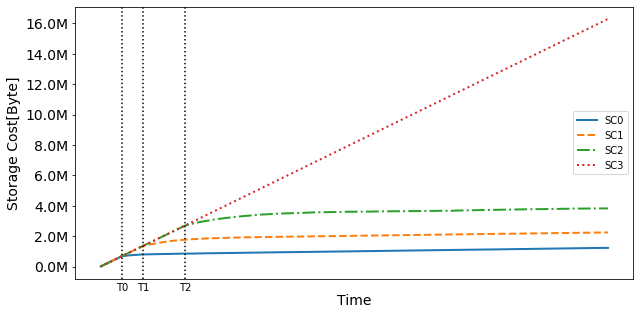

AvgStorageCostTimeExponential
Avg.size:SC0     1.229591
Avg.size:SC1     2.243607
Avg.size:SC2     3.825622
Avg.size:SC3    16.267287
Name: 2021-12-08 16:20:00, dtype: float64


/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:67: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1 = sc[{"timestamp"}]
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_t = sc[{'Avg.queryto', 'Avg.totalquery'}]
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1[item+suf] = df_t['Avg.queryto']/df_t['Avg.totalquery']
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/1096121867.py:67: FutureWarning: Passing a set

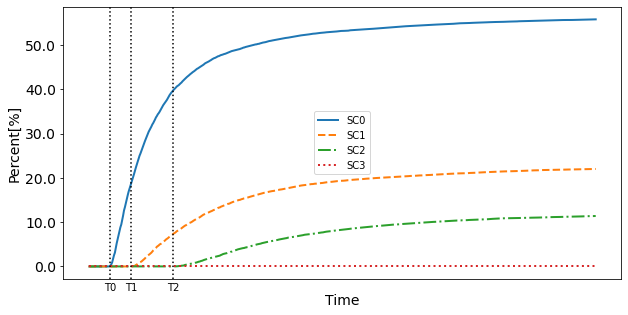

NetworkOverheadTimeExponential
NetworkOverhead:SC0    55.796482
NetworkOverhead:SC1    22.010438
NetworkOverhead:SC2    11.391340
NetworkOverhead:SC3     0.000000
Name: 2021-12-08 16:20:00, dtype: float64
Query Cost
                     delay:SC0  delay:SC1  delay:SC2  delay:SC3
timestamp                                                      
2021-12-08 16:19:00   1.952083   1.041667   0.383333        0.0


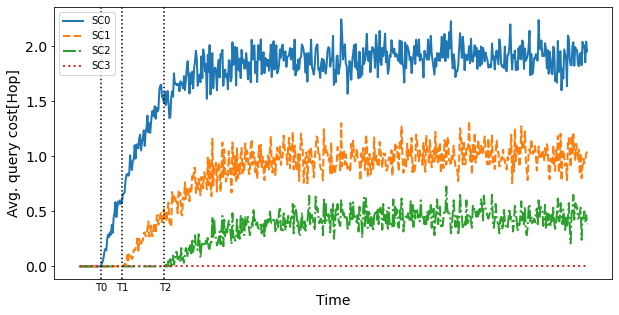

AvgTotalDelayExponential


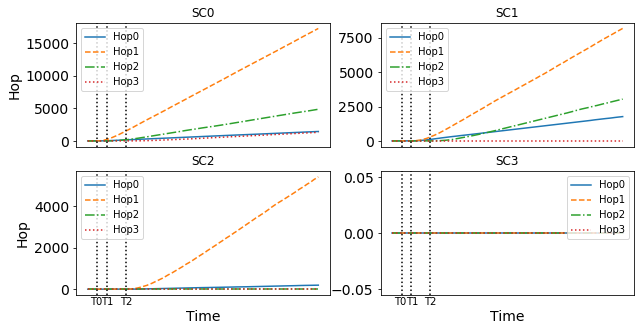

AvgTotalHopExponential
Proportion : 17.5, MLDC : 42.8MByte, BC : 244.0MByte
                     SC0        SC1        SC2    SC3
Avg. Hit Rate  47.456445  80.988246  89.002827  100.0


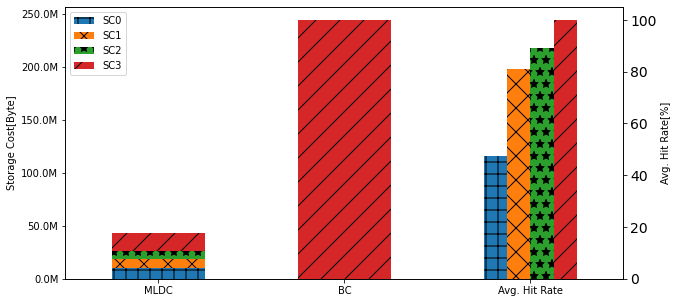

StorageCostExponential


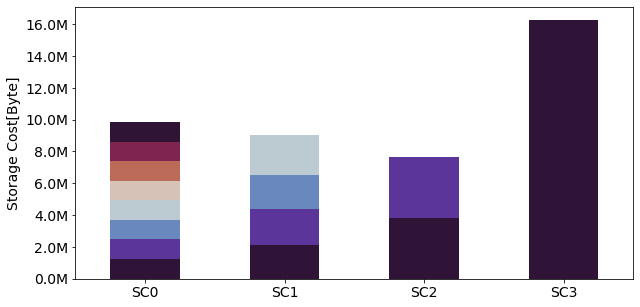

StorageCostExponential


In [10]:
show_avg_size_time_from_scs(AC_PATTERN, avg_scs, how='outer')
show_network_overhead_from_scs(AC_PATTERN, avg_scs, how='outer')
show_network_delay_from_scs(AC_PATTERN, avg_scs, how='outer')
show_network_hop_from_scs(AC_PATTERN, avg_scs, how='outer')
show_storage_size_from_scs(AC_PATTERN, total_scs, how='outer')
show_storage_size_from_scs2(AC_PATTERN, total_scs, how='outer')

/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

timestamp
2021-12-08 07:04:00        0.000
2021-12-08 07:05:00        2.500
2021-12-08 07:06:00        5.625
2021-12-08 07:07:00       12.000
2021-12-08 07:08:00       17.875
                         ...    
2021-12-08 16:16:00    44151.625
2021-12-08 16:17:00    44237.500
2021-12-08 16:18:00    44326.375
2021-12-08 16:19:00    44413.000
2021-12-08 16:20:00    44440.750
Name: Avg.totalquery, Length: 557, dtype: float64
timestamp
2021-12-08 07:04:00       NaN
2021-12-08 07:05:00     0.000
2021-12-08 07:06:00     0.000
2021-12-08 07:07:00     0.000
2021-12-08 07:08:00     0.000
                        ...  
2021-12-08 16:15:00    52.875
2021-12-08 16:16:00    52.375
2021-12-08 16:17:00    48.625
2021-12-08 16:18:00    54.625
2021-12-08 16:19:00    50.625
Name: Avg.queryto, Length: 556, dtype: float64


/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

timestamp
2021-12-08 07:04:00        0.50
2021-12-08 07:05:00        1.50
2021-12-08 07:06:00        4.00
2021-12-08 07:07:00       10.00
2021-12-08 07:08:00       16.00
                         ...   
2021-12-08 16:16:00    58528.25
2021-12-08 16:17:00    58641.75
2021-12-08 16:18:00    58763.25
2021-12-08 16:19:00    58880.00
2021-12-08 16:20:00    58917.50
Name: Avg.totalquery, Length: 557, dtype: float64
timestamp
2021-12-08 07:04:00      NaN
2021-12-08 07:05:00     0.00
2021-12-08 07:06:00     0.00
2021-12-08 07:07:00     0.00
2021-12-08 07:08:00     0.00
                       ...  
2021-12-08 16:15:00    28.25
2021-12-08 16:16:00    26.75
2021-12-08 16:17:00    27.25
2021-12-08 16:18:00    28.75
2021-12-08 16:19:00    29.50
Name: Avg.queryto, Length: 556, dtype: float64


/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

timestamp
2021-12-08 07:04:00        0.0
2021-12-08 07:05:00        1.5
2021-12-08 07:06:00        3.5
2021-12-08 07:07:00        8.0
2021-12-08 07:08:00       16.0
                        ...   
2021-12-08 16:16:00    49010.5
2021-12-08 16:17:00    49109.5
2021-12-08 16:18:00    49209.0
2021-12-08 16:19:00    49310.5
2021-12-08 16:20:00    49344.5
Name: Avg.totalquery, Length: 557, dtype: float64
timestamp
2021-12-08 07:04:00     NaN
2021-12-08 07:05:00     0.0
2021-12-08 07:06:00     0.0
2021-12-08 07:07:00     0.0
2021-12-08 07:08:00     0.0
                       ... 
2021-12-08 16:15:00    13.5
2021-12-08 16:16:00    15.0
2021-12-08 16:17:00    12.0
2021-12-08 16:18:00    14.5
2021-12-08 16:19:00    11.5
Name: Avg.queryto, Length: 556, dtype: float64


/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg.'+column] = df.mean(numeric_only=True, axis=1)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/2583415359.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

timestamp
2021-12-08 07:04:00        0.0
2021-12-08 07:05:00        1.0
2021-12-08 07:06:00        3.0
2021-12-08 07:07:00        7.0
2021-12-08 07:08:00       16.0
                        ...   
2021-12-08 16:16:00    40810.0
2021-12-08 16:17:00    40892.0
2021-12-08 16:18:00    40977.0
2021-12-08 16:19:00    41059.0
2021-12-08 16:20:00    41093.0
Name: Avg.totalquery, Length: 557, dtype: float64
timestamp
2021-12-08 07:04:00    NaN
2021-12-08 07:05:00    0.0
2021-12-08 07:06:00    0.0
2021-12-08 07:07:00    0.0
2021-12-08 07:08:00    0.0
                      ... 
2021-12-08 16:15:00    0.0
2021-12-08 16:16:00    0.0
2021-12-08 16:17:00    0.0
2021-12-08 16:18:00    0.0
2021-12-08 16:19:00    0.0
Name: Avg.queryto, Length: 556, dtype: float64


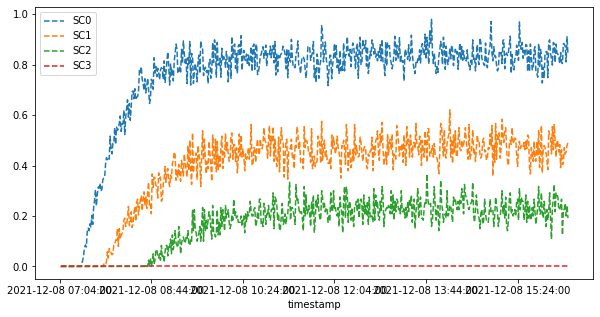

In [11]:
def load_data_from_db_t(dbs):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
#         query_cmd = 'SELECT timestamp, totalquery, queryfrom, queryto, totaldelay, hop0, hop1, hop2, hop3 FROM dbstatus;'
        query_cmd = 'SELECT strftime("%Y-%m-%d %H:%M:00",timestamp) as timestamp, \
        totalquery, queryto, totaldelay, hop0, hop1, hop2, hop3 FROM dbstatus \
        WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY strftime("%Y-%M-%d %H:%m",timestamp));'

        df = pd.read_sql_query(query_cmd, conn)
        #df = df.set_index('timestamp')
        #df = df.diff()

        sc.append(df)
        conn.close()

    return sc

COLS = ['totalquery', 'queryfrom', 'queryto', 'totaldelay', 'hop0', 'hop1', 'hop2', 'hop3', 'timestamp']
NODE_LIST = [["7001.db", "7002.db", "7003.db", "7004.db", "7005.db", "7006.db", "7007.db", "7008.db"],
                ["7011.db", "7012.db", "7013.db", "7014.db"],
                ["7021.db", "7022.db"],
                ["7031.db"]]

labels = ['SC0', 'SC1', 'SC2', 'SC3']

for i, nodes in enumerate(NODE_LIST):
    scs = load_data_from_db_t(nodes)
    merged_sc = merge_class_by_timestamp(scs, how='outer')    
    avg_df = get_everage_sc(COLS[:-1], merged_sc)
    avg_df.fillna(method='ffill', inplace=True)
    avg_df.fillna(method='backfill', inplace=True)
    avg_df = avg_df.set_index('timestamp')
    
    ax = plt.gca()
    print(avg_df['Avg.totalquery'])
    avg_df = avg_df.diff()

#     avg_df.plot(kind='line', y='Avg.queryto', linestyle='--', ax=ax, figsize=(20, 5))
    
#     avg_df['delay'] = avg_df['Avg.totaldelay'] / avg_df['Avg.queryto']
#     avg_df.plot(kind='line', y='delay', linestyle='--', ax=ax, figsize=(20, 5))

    avg_df.drop(avg_df.tail(1).index,inplace=True)    
    #avg_df[labels[i]]= (avg_df['Avg.hop0'] + avg_df['Avg.hop1']*2 + avg_df['Avg.hop2']*3 + avg_df['Avg.hop3']*4)
    avg_df[labels[i]]= avg_df['Avg.queryto']/60
    print(avg_df['Avg.queryto'])
    avg_df.plot(kind='line', y=labels[i], linestyle='--', ax=ax, figsize=(10, 5))
    

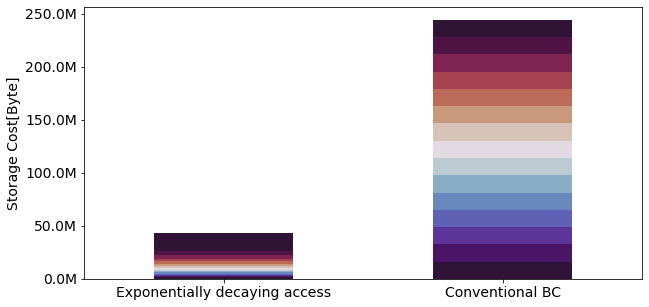

StorageCostExponential


In [12]:
COLS = ['size', 'timestamp']
NODE_LIST = [["7001.db", "7002.db", "7003.db", "7004.db", "7005.db", "7006.db", "7007.db", "7008.db"],
                ["7011.db", "7012.db", "7013.db", "7014.db"],
                ["7021.db", "7022.db"],
                ["7031.db"]]

labels = ['SC0', 'SC1', 'SC2', 'SC3']

total_scs = []

for nodes in NODE_LIST[:]:
    #scs = load_data_from_db(nodes)
    scs = load_data_from_db_min(nodes)
    total_scs.append(scs)
#     print(scs)

def show_total_storage_size(acp, total_scs, how='inner'):  
    columns=['Node%d' %x for x in range(15)]
    index=['Exponentially decaying access', 'Conventional BC']
    df = pd.DataFrame(index=index, columns=columns)
    
    pos = 0
    last = 0
    for i, scs in enumerate(total_scs):
        size = 0
        for j, sc in enumerate(scs):
            size = sc['size'].max()
            df.at[index[0], columns[pos]] = size
            last = size
            pos += 1

    for i, _ in enumerate(columns):
        df.at[index[1], columns[i]] = last
        
    df = df.fillna(0)
    
    cmap = mcolors.LinearSegmentedColormap.from_list('blue_to_red', ['darkblue', 'darkred'])


    ax = plt.gca()    
    def millions(x, pos):
        #'The two args are the value and tick position'
        return '%1.1fM' % (x*1e-6)
    formatter = FuncFormatter(millions)
    ax.yaxis.set_major_formatter(formatter)
    
    df[columns].plot(kind='bar', stacked=True, ax=ax, figsize=(10, 5), cmap='twilight_shifted')
#     df.plot(kind='bar', stacked=False, ax=ax, figsize=(10, 5))
    plt.ylabel("Storage Cost[Byte]", fontsize=FONT_SIZE)
    ax.legend().set_visible(False)
    plt.xticks(rotation=0)   
    plt.tick_params(labelsize=FONT_SIZE)
    
        
    plt.savefig('TotalStorageCost'+acp+'.png', dpi=300)
    plt.show()
    print('StorageCost'+acp) 
    
show_total_storage_size(AC_PATTERN, total_scs, how='outer')

/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/3263529771.py:25: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = avg_scs[0][{"timestamp", item}]
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/3263529771.py:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/3263529771.py:28: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
/var/folders/4w/wtwh99qn6cn3y4y5lpnm9nv00000gn/T/ipykernel_836/3263529771.py:28: FutureWarning: Passing a set as an indexer is deprecated and will ra

[ 123.099725  224.8784    383.11365  1626.7287  ]
[55.79648183 22.01086957 11.39134047  0.        ]
[1.95208333 1.04166667 0.38333333 0.        ]


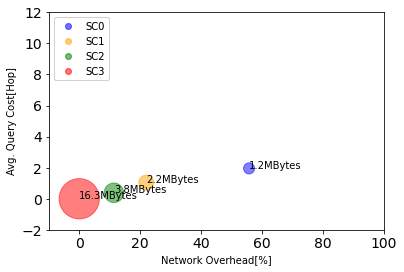

In [7]:
COLS = COLS = ['headers', 'transactions', 'size', 'totalquery', 'queryfrom', 'queryto', 'totaldelay', 'hop0', 'hop1', 'hop2', 'hop3', 'timestamp']
NODE_LIST = [["7001.db", "7002.db", "7003.db", "7004.db", "7005.db", "7006.db", "7007.db", "7008.db"],
                ["7011.db", "7012.db", "7013.db", "7014.db"],
                ["7021.db", "7022.db"],
                ["7031.db"]]

labels = ['SC0', 'SC1', 'SC2', 'SC3']

total_scs = []

for nodes in NODE_LIST[:]:
    #scs = load_data_from_db(nodes)
    scs = load_data_from_db_min(nodes)
    total_scs.append(scs)
#     print(scs)

def show_scater_plot(acp, total_scs, how='inner'):  
    from matplotlib.colors import ListedColormap
#     colors = ['blue', 'orange', 'green', 'red']
    colors = ListedColormap(['blue', 'orange', 'green', 'red'])
    
    labels = ['SC0', 'SC1', 'SC2', 'SC3']
    item = "Avg.size"
    
    df = avg_scs[0][{"timestamp", item}]
    for i, sc in enumerate(avg_scs[1:]):
        suf = ':SC%d' % (i+1)
        df = pd.merge(left = df, right=sc[{"timestamp", item}], how=how, on ='timestamp', suffixes=('', suf), sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df = df.set_index('timestamp')
    df = df.rename(columns={item: item+":SC0"})
    storage_cost = df.max()
    storage_cost_label = storage_cost/1000000
    storage_cost_label = ["%.1fMBytes" % x for x in storage_cost_label]
    storage_cost = storage_cost.values/10000
    
    print(storage_cost)
    
    item = "NetworkOverhead"

    df_list = []
    for i, sc in enumerate(avg_scs):
        suf = ':SC%d' % (i)
        df1 = sc[{"timestamp"}]
        df_t = sc[{'Avg.queryto', 'Avg.totalquery'}]
        
        df1[item+suf] = df_t['Avg.queryto']/df_t['Avg.totalquery']
        df_list.append(df1)
        
    df = df_list[0]
    for i, sc in enumerate(df_list[1:]):
        df = pd.merge(left = df, right=sc, how=how, on ='timestamp', sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df = df.set_index('timestamp')    
    network_overhead = df.max()*100
    network_overhead = network_overhead.values
    print(network_overhead)
    
    items = ["timestamp",'Avg.queryto', "Avg.hop0", "Avg.hop1", "Avg.hop2", "Avg.hop3"] 
    
    df = avg_scs[0].filter(items=items)
    for i, sc in enumerate(avg_scs[1:]):
        suf = ':SC%d' % (i+1)
        df = pd.merge(left = df, right=sc.filter(items=items), how=how, on ='timestamp', suffixes=('', suf), sort=True)
    
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='backfill', inplace=True)
    df = df.set_index('timestamp')
    #################################### Show diff
    df = df.diff()
    df.drop(df.tail(1).index,inplace=True)
    
    for item in items[1:]:
        df = df.rename(columns={item: item+":SC0"})
    
    df['delay:SC0'] = (df['Avg.hop0:SC0'] + df['Avg.hop1:SC0']*2 + df['Avg.hop2:SC0']*3 + df['Avg.hop3:SC0']*4)/ 60
    df['delay:SC1'] = (df['Avg.hop0:SC1'] + df['Avg.hop1:SC1']*2 + df['Avg.hop2:SC1']*3 + df['Avg.hop3:SC1']*4)/ 60
    df['delay:SC2'] = (df['Avg.hop0:SC2'] + df['Avg.hop1:SC2']*2 + df['Avg.hop2:SC2']*3 + df['Avg.hop3:SC2']*4)/ 60
    df['delay:SC3'] = (df['Avg.hop0:SC3'] + df['Avg.hop1:SC3']*2 + df['Avg.hop2:SC3']*3 + df['Avg.hop3:SC3']*4)/ 60
    
    avg_query_cost = df.filter(items=['delay:SC0', 'delay:SC1', 'delay:SC2','delay:SC3']).iloc[[-1]]    
    avg_query_cost = avg_query_cost.values[0]
    print(avg_query_cost)
    
    labels_sc = ['SC0', 'SC1', 'SC2', 'SC3']
    
    fig, ax = plt.subplots()
    scatter = plt.scatter(network_overhead, avg_query_cost, c=[0, 1, 2, 3], s=storage_cost, cmap=colors, alpha=0.5)
    handles1, _ = scatter.legend_elements(prop="colors")
    legend1 = ax.legend(handles1, labels_sc, loc="upper left")
    ax.add_artist(legend1)
#     handles2, _ = scatter.legend_elements(prop="sizes", alpha=0.6)
#     legend2 = ax.legend(handles2, storage_cost_label, loc="lower right", title="Storage Cost", labelspacing=2.5)
    for i, txt in enumerate(storage_cost_label):
        ax.annotate(txt, (network_overhead[i], avg_query_cost[i]))

    plt.xlabel("Network Overhead[%]")
    plt.ylabel("Avg. Query Cost[Hop]")
    plt.tick_params(labelsize=FONT_SIZE)
    plt.xlim(-10, 100)
    plt.ylim(-2, 12)
        
    plt.savefig('ScatterChart'+acp+'.png', dpi=300)
    plt.show()

    
show_scater_plot(AC_PATTERN, total_scs, how='outer')